In [4]:
with open("./splits/milk.split.bundle", "w") as new_file:
    with open("./splits/train.split1.bundle","r") as cur_file:
        new_file.write("#bundle\n")
        while True:
            line = cur_file.readline()
            if not line:
                break
            if "milk" in line:
                new_file.write(line)

In [1]:
from utils.read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np
import torch
from Dataset.SegmentDataset import SegmentDataset

import torch.utils.data as tud
from torch.utils.data.sampler import WeightedRandomSampler

#from Models.Conv import model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.nn as nn
from evaluation import evaluation
from datetime import datetime
import utils.balance_data as b
import random

COMP_PATH = ''
split = 'training'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/milk.split.bundle') #Train Split
# train_split =  os.path.join(COMP_PATH, 'splits/dev_train.split1.bundle') #Train Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt')

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #

Finish Load the Training data and labels!!!


In [2]:
milk_data_labels = np.asarray(data_labels)
unique_labels = np.unique(milk_data_labels)
original_to_milk_label = {}
milk_to_original_label = {}
counter = 0
for i in unique_labels:
    original_to_milk_label[int(i)] = counter
    milk_to_original_label[counter] = int(i)
    milk_data_labels[milk_data_labels == i] = counter
    counter += 1

In [3]:
train_data_feat = data_feat[:-100]
train_data_label = milk_data_labels[:-100]

val_data_feat = data_feat[-100:]
val_data_label = milk_data_labels[-100:]


In [36]:
model = nn.Sequential(
    nn.Conv1d(400, 256, 3, stride = 2),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Conv1d(256, 256, 3, stride = 2),   # batch, chnel,w
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Conv1d(256, 256, 3, stride = 2),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    # nn.AdaptiveAvgPool1d(20),
    # nn.MaxPool1d(2),

    # nn.Conv1d(256, 256, 3, stride = 2),   # batch, chnel,w
    # nn.BatchNorm1d(256),
    # nn.ReLU(),

    # nn.Conv1d(256, 256, 3, stride = 2),
    # nn.BatchNorm1d(256),
    # nn.ReLU(),

    nn.AdaptiveAvgPool1d(20),

    nn.Flatten(),   
    nn.Linear(5120, 1024), 
    nn.BatchNorm1d(1024), 
    nn.ReLU(),

    nn.Linear(1024, 256), 
    nn.BatchNorm1d(256), 
    nn.ReLU(),

    nn.Dropout(0.2),
    nn.Linear(256, 4)
)

In [37]:
cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")
epochs = 50
batch_size = 20

learning_rate = 1e-3
log_interval = 15
valid_interval = 10

valid_dataset = SegmentDataset(val_data_feat, val_data_label, seed = 2)
valid_dataloader = tud.DataLoader(valid_dataset, 
    batch_size=batch_size, 
    shuffle=False)

model = model.to(device).double()
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate, weight_decay=1e-5)

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()

    losses = []
    scores = []
    for batch_idx, (in_feature, label) in enumerate(train_loader):
        in_feature = in_feature.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(in_feature)
        output = output.view(-1, 4)
        label = label.flatten()
        loss = F.cross_entropy(output, label)
        losses.append(loss.item())
        
        #step_score = accuracy_score(label.cpu().data.squeeze().numpy(), label_predict.cpu().data.squeeze().numpy())
        # bottleneck? 
        with torch.no_grad():
            label_predict = torch.max(output, 1)[1]
            correct = (label_predict == label).sum().item()
            step_score = correct / len(label)
            scores.append(step_score)

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, (batch_idx + 1) * batch_size, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores

In [38]:
def evaluation(model, val_dataloader, type='segment'):

    predict_labels = []
    top_5_predict_labels = []
    groundTruth_labels = []
    outputs = []

    predict_scores = []
    top_5_scores = []

    model.eval()
    for x, labels in val_dataloader:
        x, labels = x.to(device), labels.to(device)

        with torch.no_grad():
            output = model(x).to(device)
            output = output.view(-1, 4)
            predict_label = torch.max(output, 1)[1]
            labels = labels.flatten()
            top_5_predict_label = torch.topk(output, k=2, dim=1)[1]
            outputs.extend(output.tolist())

        top_5_scores.append(torch.sum(top_5_predict_label == labels.unsqueeze(dim=1)).item())
        top_5_predict_labels.extend(top_5_predict_label.tolist())


        labels = labels.cpu().data.squeeze().numpy()
        predict_label = predict_label.long().cpu().data.squeeze().numpy()

        # frame check
        # print(labels, predict_label, labels)
        
        if labels.size > 1:
            #step_score = accuracy_score(labels, predict_label)
            step_score = np.sum(labels == predict_label)
        else:
            step_score = 1 if labels == predict_label else 0
            labels = np.array([labels])
            predict_label = np.array([predict_label])
            # print(predict_label, labels)

        # print('step score', step_score)
        predict_scores.append(step_score)
        
        predict_labels.extend(predict_label.tolist())
        groundTruth_labels.extend(labels.tolist())
        
    seg_acc = sum(predict_scores) / len(predict_labels)
    top_5_seg_scc = sum(top_5_scores) / len(predict_labels)

        # result
    res = {
            'seg': {
                'acc': seg_acc,
                'predict': predict_labels,
                'groundTruth': groundTruth_labels,
                'output': outputs
            }
        }

    print('valid seg acc:', seg_acc, '\n')
    print('valid top_5_seg_scc:', top_5_seg_scc, '\n')
    return res
    

In [39]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_frame_scores = []
epoch_test_seg_scores = []


for epoch in range(epochs):
    # print('begin balance')        
    # new dataset

    # 30 pick 1
    seed = random.randint(0, 30)
    dataset = SegmentDataset(train_data_feat, train_data_label, seed=seed)
    dataloader = tud.DataLoader(dataset, 
        batch_size=batch_size, 
        shuffle=True
    )

    train_losses, train_scores = train(log_interval, model, device, dataloader, optimizer, epoch)

    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)

    # validation
    if (epoch + 1) % valid_interval == 0:
        res = evaluation(model, valid_dataloader, type='segment')

        # frame result may not exist
        if 'frame' in res:
            epoch_test_frame_scores.append(res['frame']['acc'])
        epoch_test_seg_scores.append(res['seg']['acc'])

A = np.array(epoch_train_losses)
B = np.array(epoch_train_scores)

C = np.array(epoch_test_frame_scores)
D = np.array(epoch_test_seg_scores)

Train Epoch: 1 [300/297 (100%)]	Loss: 0.324135, Accu: 82.35%
Train Epoch: 2 [300/297 (100%)]	Loss: 0.228146, Accu: 88.24%
Train Epoch: 3 [300/297 (100%)]	Loss: 0.282843, Accu: 88.24%
Train Epoch: 4 [300/297 (100%)]	Loss: 0.448529, Accu: 82.35%
Train Epoch: 5 [300/297 (100%)]	Loss: 0.053769, Accu: 100.00%
Train Epoch: 6 [300/297 (100%)]	Loss: 0.056759, Accu: 100.00%
Train Epoch: 7 [300/297 (100%)]	Loss: 0.006768, Accu: 100.00%
Train Epoch: 8 [300/297 (100%)]	Loss: 0.018785, Accu: 100.00%
Train Epoch: 9 [300/297 (100%)]	Loss: 0.114568, Accu: 94.12%
Train Epoch: 10 [300/297 (100%)]	Loss: 0.256872, Accu: 94.12%
valid seg acc: 0.8235294117647058 

valid top_5_seg_scc: 0.9264705882352942 

Train Epoch: 11 [300/297 (100%)]	Loss: 0.018020, Accu: 100.00%
Train Epoch: 12 [300/297 (100%)]	Loss: 0.039974, Accu: 100.00%
Train Epoch: 13 [300/297 (100%)]	Loss: 0.013577, Accu: 100.00%
Train Epoch: 14 [300/297 (100%)]	Loss: 0.006017, Accu: 100.00%
Train Epoch: 15 [300/297 (100%)]	Loss: 0.006554, Accu: 

In [15]:
print(D)

[0.82352941 0.85294118 0.83823529 0.82352941 0.86764706]


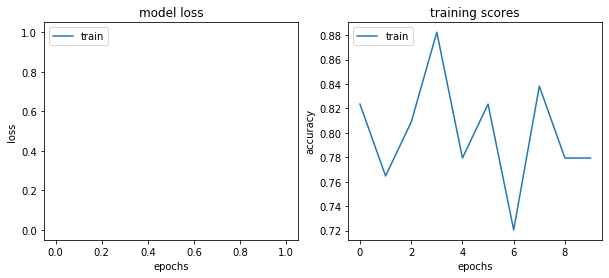

In [40]:
import matplotlib.pyplot as plt
import numpy as np


#C = np.load('./results/lstm/test_loss_2020-03-28.npy')
#D = np.load('./results/lstm/test_score_2020-03-29.npy')
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
#plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(C.flatten())  # train loss (on epoch end)
#plt.plot(np.arange(1, epochs + 1), C)  
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc="upper left")
# 2nd figure
plt.subplot(122)


plt.plot(D.flatten()) # train accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
plt.show()
